#### Graph Convolutions

In [1]:
import numpy as np
import networkx as nx

In [3]:
G = nx.Graph()
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
G.add_nodes_from([
     (1, {"color": blue}),
     (2, {"color": orange}),
     (3, {"color": blue}),
     (4, {"color": green})
    ])
G.add_edges_from([(1,2), (2,3), (1,3), (3,4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [ ]:
def build_graph_color_label_representation(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in
                             nx.get_node_attributes(G, 'color').values()])
    print(one_hot_idxs)
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1

    return one_hot_encoding

In [9]:
X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
X

[1 2 1 0]


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

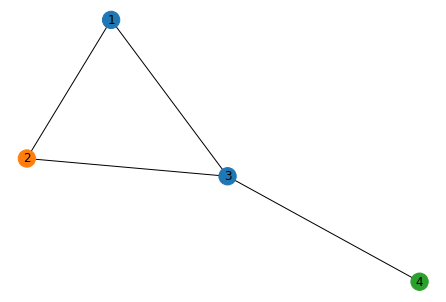

In [10]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G,with_labels=True, node_color=color_map)

##### Forward pass of graph convolution

Ultimately, we want a graph convolutional layer to update the representation of the node information encoded in X by utilizing the structural (connectivity) information provided by A.

In [12]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X, W_1) + np.dot(np.dot(A, X), W_2)
h

array([[1.65010829, 1.79152823, 1.46387061, 1.0703135 , 1.01340164,
        2.3765821 ],
       [1.55734765, 0.55059816, 0.58224682, 1.01114089, 1.5545072 ,
        2.87260721],
       [1.65247517, 2.61477209, 2.17712449, 1.3280419 , 1.19665014,
        2.98668874],
       [0.83160413, 1.03347976, 0.73926697, 1.282822  , 0.63756764,
        1.05645065]])

#### GNN implementation

In [16]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F

In [17]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W2 = Parameter(torch.rand(
            (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
            (in_channels, out_channels), dtype=torch.float32))
        self.bias = Parameter(torch.zeros(
            out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

In [18]:
# aggregate all of a graph's node embeddings into a fixed-sized output
# results in loss of information
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [40]:
class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A, batch_mat):
        # perform two convolutions
        x = F.relu(self.conv_1(X, A))
        x = F.relu(self.conv_2(x, A))
        # pool all the node embeddings
        output = global_sum_pool(x, batch_mat)
        # run pooled embeddings through dense layers (embed state of whole graph?)
        output = self.fc_1(output)
        output = self.out_layer(output)
        # output class membership probability via softmax
        return F.softmax(output, dim=1)

##### Batching

When all data in a dataset has the same dimensionality, batching the data is as straightforward as adding a dimension by stacking the data.
Since graph sizes vary, this approach is not feasible with
graph data unless padding is used. However, padding can be inefficient in cases where graph sizes can vary substantially. Usually, the better way to deal with varying graph sizes is to treat each batch as a single graph where each graph in the batch is a subgraph that is disconnected from the rest.

**batch_mat** - this is the purpose of batch_mat in global_sum_pool() —to serve as a **graph selection mask** that
keeps the graphs in the batch separate.

In [32]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx])
              for idx in range(len(graph_sizes))]
    stops = [starts[idx] + graph_sizes[idx]
             for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
    stop = starts_and_stops[1]
    batch_mat[idx,start:stop] = 1
    return batch_mat

In [33]:
# batch is a list of dictionaries each containing
# the representation and label of a graph
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size,accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {'A': batch_adj,
                      'X': feat_mats, 'y': labels,
                      'batch': batch_mat}
    return repr_and_label

#### Dataloader

In [34]:
# Function builds dictionary representation of graph G
def get_graph_dict(G, mapping_dict):
    A = torch.from_numpy(
        np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation()
    # was introduced with the first example graph
    X = torch.from_numpy(
        build_graph_color_label_representation(
            G, mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1,0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

##### Build sample data 

In [35]:
# building 4 graphs to treat as a dataset
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict= {green:0, blue:1, orange:2}
G1 = nx.Graph()
G1.add_nodes_from([
     (1,{"color": blue}),
     (2,{"color": orange}),
     (3,{"color": blue}),
])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([
    (1,{"color": green}),
    (2,{"color": green}),
    (3,{"color": orange}),
    (4,{"color": orange}),
    (5,{"color": blue})
    ])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([
    (1,{"color": orange}),
    (2,{"color": orange}),
    (3,{"color": green}),
    (4,{"color": green}),
    (5,{"color": blue}),
    (6,{"color":orange})
    ])
G3.add_edges_from([(2,3), (3,4), (3,1), (5,1), (2,5), (6,1)])
G4 = nx.Graph()
G4.add_nodes_from([
    (1,{"color": blue}),
    (2,{"color": blue}),
    (3,{"color": green})
    ])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]]

[1 2 1]
[0 0 2 2 1]
[2 2 0 0 1 2]
[1 1 0]


##### PyTorch Dataset

In [36]:
from torch.utils.data import Dataset
class ExampleDataset(Dataset):
    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [37]:
from torch.utils.data import DataLoader
dset = ExampleDataset(graph_list)
# Note how we use our custom collate function
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

##### Use the network

In [ ]:
node_features = 3
net = NodeNetwork(node_features)
batch_results = []
for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())